In [1]:
import sys
sys.path.append("../")

In [2]:
from loss import compute_loss
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [3]:
input_nc = 1
output_nc = 1
discr_filters = 8
max_power = 8
n_layers = 4
norm_lay = nn.BatchNorm2d
start_size = 28
gen_filters = 16
dropout = 0.7
n_blocks = 2
batch_size = 11
alpha = 3

In [4]:
train_pull = pd.read_csv("../../../data/fashion_mnisit/train_pull.csv", header=None).values
train_top = pd.read_csv("../../../data/fashion_mnisit/train_top.csv", header=None).values
# test_pull = pd.read_csv("../../data/fashion_mnisit/test_pull.csv", header=None).values
# test_top = pd.read_csv("../../data/fashion_mnisit/test_top.csv", header=None).values

In [5]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size)

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size)

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

In [6]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [7]:
opt_gener_a = torch.optim.Adam(gener_a.parameters(), lr=0.001)
opt_gener_b = torch.optim.Adam(gener_b.parameters(), lr=0.001)
opt_discr_a = torch.optim.Adam(discr_a.parameters(), lr=0.001)
opt_discr_b = torch.optim.Adam(discr_b.parameters(), lr=0.001)

In [8]:
set_names(discr_a, discr_b,
          gener_a, gener_b,
          opt_gener_a, opt_gener_b,
          opt_discr_a, opt_discr_b)

In [9]:
ga_loss_log = []
gb_loss_log = []
da_loss_log = []
db_loss_log = []

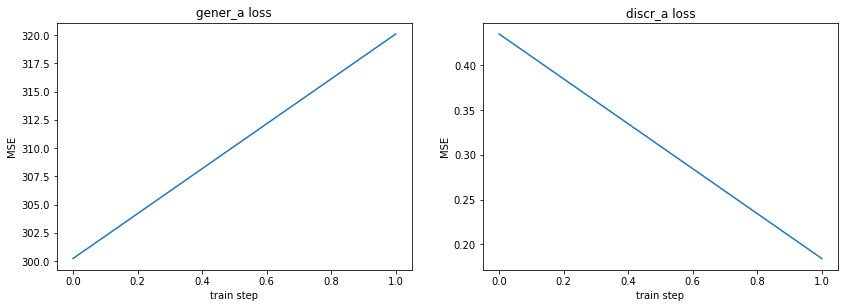

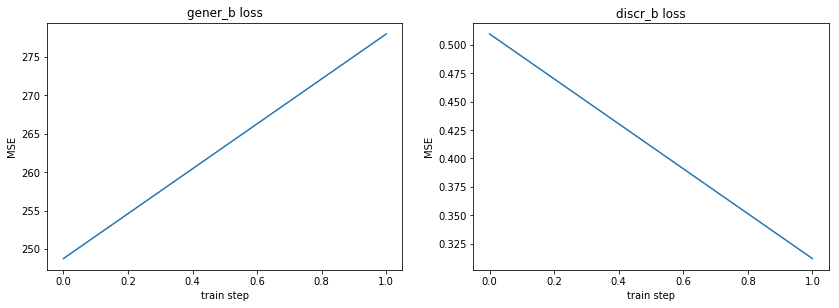

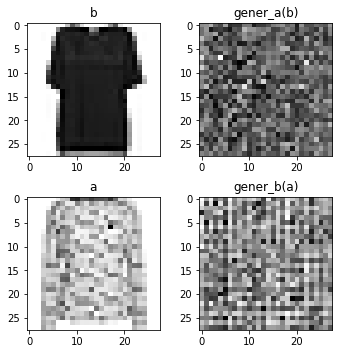

In [10]:
for i in range(8, 10):
    batch_a, batch_b = data_sampler(batch_size, train_pull, train_top)
    batch_a = batch_a.view(-1, 1, 28, 28).float()
    batch_b = batch_b.view(-1, 1, 28, 28).float()
    gener_a.train()
    gener_b.train()
    discr_a.train()
    discr_b.train()
    
    da_loss, db_loss, ga_loss, gb_loss = compute_loss(gener_a, gener_b,
                                                      discr_a, discr_b,
                                                      batch_a, batch_b,
                                                      alpha)
    if i % 2 == 0:
        opt_discr_a.zero_grad()
        da_loss.backward(retain_graph=True)
        opt_discr_a.step()
        opt_discr_b.zero_grad()
        db_loss.backward()
        opt_discr_b.step()
    else:
        opt_gener_a.zero_grad()
        ga_loss.backward(retain_graph=True)
        opt_gener_a.step()
        opt_gener_b.zero_grad()
        gb_loss.backward()
        opt_gener_b.step()
    
    ga_loss_log.append(ga_loss.data[0])
    gb_loss_log.append(gb_loss.data[0])
    da_loss_log.append(da_loss.data[0])
    db_loss_log.append(db_loss.data[0])
    
    if (i+1) % 10 == 0:
        clear_output()
        plt.figure(figsize=(14, 10))

        plt.subplot(2, 2, 1)
        plt.plot(ga_loss_log)
        plt.title("gener_a loss")
        plt.xlabel("train step")
        plt.ylabel("MSE")

        plt.subplot(2, 2, 2)
        plt.plot(da_loss_log)
        plt.title("discr_a loss")
        plt.xlabel("train step")
        plt.ylabel("MSE")


        plt.figure(figsize=(14, 10))
        plt.subplot(2, 2, 1)
        plt.plot(gb_loss_log)
        plt.title("gener_b loss")
        plt.xlabel("train step")
        plt.ylabel("MSE")

        plt.subplot(2, 2, 2)
        plt.plot(db_loss_log)
        plt.title("discr_b loss")
        plt.xlabel("train step")
        plt.ylabel("MSE")
        plt.show()
        
        ind = np.random.randint(0, batch_size, 1, dtype=int)[0]
        sample_a, sample_b = data_sampler(1, train_pull, train_top)

        plt.figure(figsize=(5, 5))
        plt.tight_layout()

        plt.subplot(2, 2, 1)
        plt.imshow(sample_b.view(1, 1, 28, 28).data[0].numpy().reshape((28, 28)), cmap='binary')
        plt.title("b")

        plt.subplot(2, 2, 2)
        plt.tight_layout()
        plt.imshow(gener_a(sample_b.view(1, 1, 28, 28)).data[0].numpy().reshape((28, 28)), cmap='binary')
        plt.title("gener_a(b)")

        plt.subplot(2, 2, 3)
        plt.tight_layout()
        plt.imshow(sample_a.view(1, 1, 28, 28).data[0].numpy().reshape((28, 28)), cmap='binary')
        plt.title("a")

        plt.subplot(2, 2, 4)
        plt.tight_layout()
        plt.imshow(gener_b(sample_a.view(1, 1, 28, 28)).data[0].numpy().reshape((28, 28)), cmap='binary')
        plt.title("gener_b(a)")
        
        plt.show()

In [11]:
state = create_checkpoint(discr_a, discr_b, gener_a, gener_b,
                          opt_gener_a, opt_gener_b, opt_discr_a, opt_discr_b)
torch.save(state, "checkpoint_{}.tar"
          .format(dt.datetime.now().strftime("%y%m%d_%H%M%S")))

In [14]:
checkpoint = torch.load("checkpoint_180228_091736.tar")

In [16]:
checkpoint.keys()

odict_keys(['discr_a', 'discr_b', 'gener_a', 'gener_b', 'opt_gener_a', 'opt_gener_b', 'opt_discr_a', 'opt_discr_b'])

In [27]:
discr_a = checkpoint.get('discr_a')
discr_b = checkpoint.get('discr_b')
gener_a = checkpoint.get('gener_a')
gener_b = checkpoint.get('gener_b')
opt_gener_a = checkpoint.get('opt_gener_a')
opt_gener_b = checkpoint.get('opt_gener_b')
opt_discr_a = checkpoint.get('opt_discr_a')
opt_discr_b = checkpoint.get('opt_discr_b')

In [30]:
checkpoint

OrderedDict([('discr_a', Discriminator(
                (body): Sequential(
                  (0): Conv2d (1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
                  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
                  (2): LeakyReLU(0.1)
                  (3): Conv2d (8, 22, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
                  (4): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True)
                  (5): LeakyReLU(0.1)
                  (6): Conv2d (22, 36, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
                  (7): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
                  (8): LeakyReLU(0.1)
                  (9): Conv2d (36, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
                  (10): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
                  (11): LeakyReLU(0.1)
                  (12): Conv2d (50, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
               

In [44]:
torch.load(".tar")

{'d': Discriminator(
   (body): Sequential(
     (0): Conv2d (1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
     (2): LeakyReLU(0.1)
     (3): Conv2d (8, 22, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True)
     (5): LeakyReLU(0.1)
     (6): Conv2d (22, 36, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (7): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
     (8): LeakyReLU(0.1)
     (9): Conv2d (36, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (10): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
     (11): LeakyReLU(0.1)
     (12): Conv2d (50, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (14): LeakyReLU(0.1)
     (15): Conv2d (64, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
   )
   (head): Sequential(
     (0): Linear(in_